In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from autoencoder import NonLinearAutoencoder
from solver import train_vali_all_epochs, nl_dev_train_vali_all_epochs, test

In [2]:
# CIFAR10 normalization (RGB channels)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR10 datasets
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set into train/validation
train_size = int(len(cifar_train) * 0.8)  # 40,000 samples
validation_size = len(cifar_train) - train_size  # 10,000 samples
cifar_train, cifar_val = torch.utils.data.random_split(cifar_train, [train_size, validation_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=6)
validation_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=6)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train_sae(save_path):
    sae_model = NonLinearAutoencoder(n_input=3072, n_hidden_ls=[512, 128, 32], n_layers=3)
    sae_optimizer = torch.optim.SGD(sae_model.parameters(), lr=0.1, momentum=0.9)

    sae_train_loss, sae_validation_loss = train_vali_all_epochs(
        sae_model, 
        train_loader, 
        validation_loader, 
        sae_optimizer, 
        n_epochs=10, 
        device=torch.device('cuda'), 
        save_path=save_path+'/'
        )
    
    return sae_model, sae_train_loss, sae_validation_loss


def train_dae(save_path):
    dae_model = NonLinearAutoencoder(n_input=3072, n_hidden_ls=[512, 128, 32], n_layers=3)
    dae_optimizer = torch.optim.SGD(dae_model.parameters(), lr=0.1, momentum=0.9)

    size_ls = [16, 16, 16, 16, 16, 32, 32, 32, 32, 32]

    manner = 'cell_division'

    dae_train_loss, dae_validation_loss = nl_dev_train_vali_all_epochs(
        dae_model, 
        size_ls,
        manner,
        train_loader,
        validation_loader, 
        dae_optimizer, 
        n_epochs=10,
        device=torch.device('cpu'), 
        save_path=save_path+'/'
        )
    
    return dae_model, dae_train_loss, dae_validation_loss

In [ ]:
num_models = 1
for i in range(num_models):
    # save_path looks like: /home/david/cifar_models/model_type/iteration/'
    base_dir = os.path.join(os.getenv("HOME"), "cifar_models")
    
    sae_path = os.path.join(base_dir, "sae", str(i))
    dae_path = os.path.join(base_dir, "dae", str(i))

    train_sae(sae_path)
    train_dae(dae_path)

In [4]:
def load_model(model_path, model_type, epoch):
    n_input = 3072
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [16, 16, 16, 16, 16, 32, 32, 32, 32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    hidden_layers = sae_n_hidden_ls if model_type == 'sae' else dae_n_hidden_ls
    model = NonLinearAutoencoder(n_input, hidden_layers, n_layers)

    weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [5]:
sae_model = load_model('/home/david/cifar_models/sae/0', 'sae', 9)

test(sae_model, test_loader, device=torch.device('cpu'))

/tmp/ipykernel_174930/4204711149.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
/home/david/Docume

====> Test set loss: 0.2219


(0.22193030051038234,
 tensor([[-0.8045, -0.9557, -1.0041,  ...,  0.3027,  0.4224,  0.3942],
         [ 0.2995,  0.0973,  0.0699,  ..., -0.4945, -0.5278, -0.5502],
         [-0.0101, -0.0126, -0.0602,  ...,  1.7376,  1.7747,  1.8153],
         ...,
         [-1.4156, -1.4112, -1.4639,  ..., -1.2471, -1.2094, -1.2656],
         [-1.2522, -1.2197, -1.3277,  ..., -0.3058, -0.3129, -0.3965],
         [ 0.0113, -0.0445, -0.1147,  ..., -0.6874, -0.5784, -0.5684]]),
 tensor([[[[-1.4814e+00, -1.2909e+00, -1.0051e+00,  ..., -1.3862e+00,
            -1.4338e+00, -1.4020e+00],
           [-1.5608e+00, -1.1639e+00, -1.0527e+00,  ..., -1.4020e+00,
            -1.3544e+00, -1.3226e+00],
           [-1.1163e+00, -1.0051e+00, -1.0527e+00,  ..., -1.3862e+00,
            -1.5290e+00, -1.2909e+00],
           ...,
           [ 9.1598e-01,  9.7949e-01,  9.4773e-01,  ...,  5.3494e-01,
             5.5081e-01,  8.6835e-01],
           [ 9.1598e-01,  9.4773e-01,  9.1598e-01,  ...,  1.0747e+00,
             1

In [6]:
sae_model.eval()

images, labels = next(iter(train_loader))

sample_img = images[0]  # Shape: [C, H, W]
sample_label = labels[0]  # Scalar value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6878146..1.9162182].


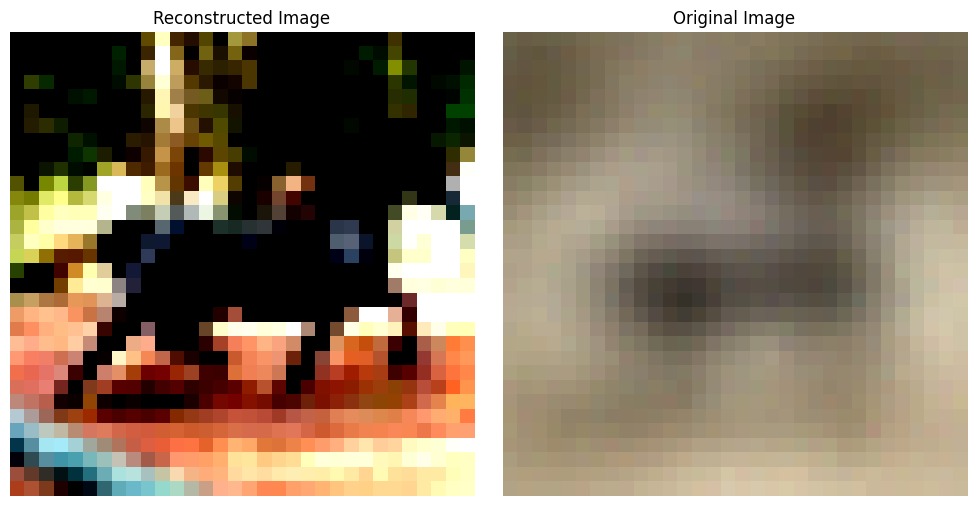

In [7]:
# Flatten the image
flat_sample_img = sample_img.view(-1)  # Shape: [C*H*W]

_, reco_sample_img = sae_model(flat_sample_img)

reco_sample_img = reco_sample_img.view(sample_img.size())  # Shape: [C, H, W]

# Denormalize the image
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])
reco_sample_img = reco_sample_img.detach().numpy().transpose(1, 2, 0)  # Convert to HxWxC
reco_sample_img = std * reco_sample_img + mean  # Denormalize
reco_sample_img = np.clip(reco_sample_img, 0, 1)  # Clip to valid range



fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img.numpy().transpose(1, 2, 0))
axes[0].set_title(f"Reconstructed Image")
axes[0].axis('off')
axes[1].imshow(reco_sample_img)
axes[1].set_title(f"Original Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [8]:
dae_model = load_model('/home/david/cifar_models/dae/0', 'dae', 9)

test(dae_model, test_loader, device=torch.device('cpu'))

/tmp/ipykernel_174930/4204711149.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
/home/david/Docume

====> Test set loss: 0.2878


(0.2877540147002739,
 tensor([[-9.8873e-01, -1.0548e+00, -9.9489e-01,  ...,  1.3621e-01,
           6.3867e-02,  7.0720e-02],
         [ 5.8070e-01,  4.9373e-01,  4.2908e-01,  ..., -1.2537e-01,
          -1.7896e-02,  1.7596e-02],
         [ 1.2215e-01,  1.0076e-01,  1.4351e-01,  ...,  1.8642e+00,
           1.8546e+00,  1.8639e+00],
         ...,
         [-1.9504e+00, -2.1369e+00, -2.0732e+00,  ..., -8.1253e-01,
          -9.0628e-01, -9.3610e-01],
         [-7.6830e-01, -7.1043e-01, -7.1419e-01,  ..., -3.5929e-01,
          -3.8726e-01, -4.0426e-01],
         [-1.9910e-02, -1.4481e-03,  1.8439e-02,  ..., -8.4085e-01,
          -8.0134e-01, -7.3916e-01]]),
 tensor([[[[-1.4814e+00, -1.2909e+00, -1.0051e+00,  ..., -1.3862e+00,
            -1.4338e+00, -1.4020e+00],
           [-1.5608e+00, -1.1639e+00, -1.0527e+00,  ..., -1.4020e+00,
            -1.3544e+00, -1.3226e+00],
           [-1.1163e+00, -1.0051e+00, -1.0527e+00,  ..., -1.3862e+00,
            -1.5290e+00, -1.2909e+00],
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6878146..1.9162182].


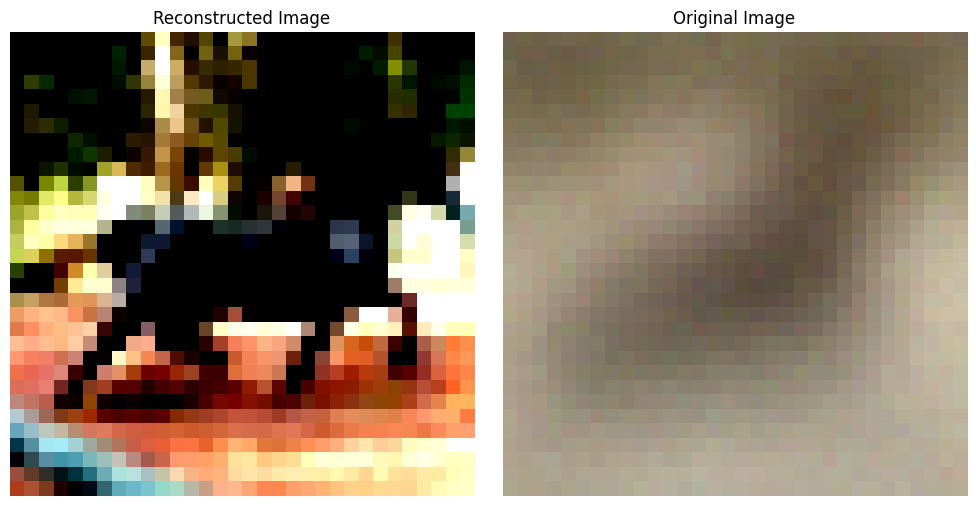

In [9]:
# Flatten the image
flat_sample_img = sample_img.view(-1)  # Shape: [C*H*W]

_, reco_sample_img = dae_model(flat_sample_img)

reco_sample_img = reco_sample_img.view(sample_img.size())  # Shape: [C, H, W]

# Denormalize the image
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])
reco_sample_img = reco_sample_img.detach().numpy().transpose(1, 2, 0)  # Convert to HxWxC
reco_sample_img = std * reco_sample_img + mean  # Denormalize
reco_sample_img = np.clip(reco_sample_img, 0, 1)  # Clip to valid range



fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img.numpy().transpose(1, 2, 0))
axes[0].set_title(f"Reconstructed Image")
axes[0].axis('off')
axes[1].imshow(reco_sample_img)
axes[1].set_title(f"Original Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()